# Face recognition using deep neural networks

### Состав команды
##Микишева Мария гр. Б03-213с
##Берёзкин Фёдор гр. Б03-212и

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # отключим

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os

save_path = SAVE_PATH = "/content/drive/MyDrive/ml_hw5"

In [ ]:
import pickle
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 as ToTensor
from tqdm import tqdm

# Section 1: Data Collection and Preparation

In [ ]:
celeba_dir = "/content/drive/MyDrive/ml_hw5/celeba"

base_data_path  = Path(f"{celeba_dir}/img_align_celeba")

identity_file   = f"{celeba_dir}/identity_CelebA.txt"
partition_file  = f"{celeba_dir}/list_eval_partition.txt"
output_dir      = Path(celeba_dir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Build a DataFrame of (image_path, id)
celeba_id_dataframe = pd.DataFrame(columns=['path', 'id'])
with open(identity_file, 'r') as f:
    data = f.read()
    for line in tqdm(data.split('\n')):
        if not line:
            continue
        name, id_ = line.split()
        celeba_id_dataframe = pd.concat([
            celeba_id_dataframe,
            pd.DataFrame({'path': [str(base_data_path / name)], 'id': [id_]})
        ], ignore_index=True)

celeba_id_dataframe.to_csv(output_dir / 'celeba_id.csv', index=False)

100%|██████████| 202600/202600 [09:53<00:00, 341.35it/s]


In [ ]:
import csv

# преобразование файла из txt в csv, иначе проблемы со чтением
input_file_p = f"{celeba_dir}/list_eval_partition.txt"
output_file_p = f"{celeba_dir}/list_eval_partition.csv"

with open(input_file_p, 'r') as infile, open(output_file_p, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['filename', 'partition'])

    for line in infile:
        filename, index = line.strip().split()
        writer.writerow([filename, int(index)])

print(f"Файл преобразован и сохранён как {output_file_p}")

Файл успешно преобразован и сохранён как /content/drive/MyDrive/ml_hw5/celeba/list_eval_partition.csv


In [ ]:
celeba_id_dataframe = pd.read_csv(output_dir / 'celeba_id.csv')

In [ ]:
# Load evaluation partition
celeba_eval_partition = pd.read_csv(output_file_p)

In [ ]:
print(celeba_eval_partition.columns)

Index(['filename', 'partition'], dtype='object')


In [ ]:
# Разделение на train / valid / test по partition
train_data = celeba_id_dataframe.loc[(celeba_eval_partition.partition == 0).values].reset_index(drop=True)
valid_data = celeba_id_dataframe.loc[(celeba_eval_partition.partition == 1).values].reset_index(drop=True)
test_data  = celeba_id_dataframe.loc[(celeba_eval_partition.partition == 2).values].reset_index(drop=True)

In [ ]:

train_data.to_csv(output_dir / 'train_data_id.csv', index=False)
valid_data.to_csv(output_dir / 'valid_data_id.csv', index=False)
test_data.to_csv(output_dir / 'test_data_id.csv', index=False)

In [ ]:
# Построение словаря в формате: id -> list of image paths
def build_id_to_paths(df: pd.DataFrame) -> dict:
    id_paths = {i: [] for i in np.unique(df.id.values)}
    for _, row in df.iterrows():
        id_paths[row.id].append(row.path)
    return id_paths

In [ ]:
id_to_paths_train = build_id_to_paths(train_data)
id_to_paths_valid = build_id_to_paths(valid_data)
id_to_paths_test  = build_id_to_paths(test_data)

# Section 2: Triplet Dataset Construction

In [ ]:
triplet_train_file = output_dir / 'triplet_train1.csv'
triplet_dataframe_train = pd.DataFrame(columns=['anchor', 'positive', 'negative'])

ids_train = list(id_to_paths_train.keys())
num_triplets_per_round = 70000

In [ ]:
for _ in range(9):
    temp_df = pd.DataFrame(columns=['anchor', 'positive', 'negative'])
    for _ in tqdm(range(num_triplets_per_round)):
        # Выбираем anchor_id с как минимум 2 картинками, а также negative_id != anchor_id
        while True:
            anchor_id, negative_id = np.random.choice(ids_train, 2, replace=False)
            if len(id_to_paths_train[anchor_id]) > 1:
                break

        anchor_list = id_to_paths_train[anchor_id]
        anchor_idx = np.random.randint(0, len(anchor_list))
        anchor_path = anchor_list[anchor_idx]

        positive_candidates = anchor_list[:anchor_idx] + anchor_list[anchor_idx + 1:]
        positive_path = np.random.choice(positive_candidates)

        negative_path = np.random.choice(id_to_paths_train[negative_id])

        temp_df = pd.concat([
            temp_df,
            pd.DataFrame({
                'anchor': [anchor_path],
                'positive': [positive_path],
                'negative': [negative_path]
            })
        ], ignore_index=True)

    triplet_dataframe_train = pd.concat([triplet_dataframe_train, temp_df], ignore_index=True)

In [ ]:
triplet_dataframe_train.to_csv(triplet_train_file, index=False)

In [ ]:
triplet_valid_file = output_dir / 'triplet_valid.csv'
triplet_dataframe_valid = pd.DataFrame(columns=['anchor', 'positive', 'negative'])

In [ ]:
ids_valid = list(id_to_paths_valid.keys())
for _ in tqdm(range(num_triplets_per_round)):
    while True:
        anchor_id, negative_id = np.random.choice(ids_valid, 2, replace=False)
        if len(id_to_paths_valid[anchor_id]) > 1:
            break

    anchor_list = id_to_paths_valid[anchor_id]
    anchor_idx = np.random.randint(0, len(anchor_list))
    anchor_path = anchor_list[anchor_idx]

    positive_candidates = anchor_list[:anchor_idx] + anchor_list[anchor_idx + 1:]
    positive_path = np.random.choice(positive_candidates)

    negative_path = np.random.choice(id_to_paths_valid[negative_id])

    triplet_dataframe_valid = pd.concat([
        triplet_dataframe_valid,
        pd.DataFrame({
            'anchor': [anchor_path],
            'positive': [positive_path],
            'negative': [negative_path]
        })
    ], ignore_index=True)

In [ ]:
triplet_dataframe_valid.to_csv(triplet_valid_file, index=False)

In [ ]:
import pandas as pd

df = pd.read_csv(f"{celeba_dir}/triplet_valid.csv")
print("Rows (без учёта заголовка):", len(df))

Rows (без учёта заголовка): 70000


In [ ]:
import pandas as pd

df = pd.read_csv(f"{celeba_dir}/triplet_train1.csv")
print("Number of triplets (строк без заголовка):", len(df))

Number of triplets (строк без заголовка): 630000


# Section 3: Verification Dataset Construction

In [ ]:
verification_valid_file = output_dir / 'verification_valid.csv'
verification_dataframe_valid = pd.DataFrame(columns=['lhs_path', 'rhs_path', 'same'])

In [ ]:
# Positive pairs (same ID)
for _ in tqdm(range(5000)):
    while True:
        id_ = np.random.choice(ids_valid)
        if len(id_to_paths_valid[id_]) > 1:
            break
    lhs_path, rhs_path = np.random.choice(id_to_paths_valid[id_], 2, replace=False)
    verification_dataframe_valid = pd.concat([
        verification_dataframe_valid,
        pd.DataFrame({'lhs_path': [lhs_path], 'rhs_path': [rhs_path], 'same': [1]})
    ], ignore_index=True)

In [ ]:
# Negative pairs (different IDs)
for _ in tqdm(range(5000)):
    id_lhs, id_rhs = np.random.choice(ids_valid, 2, replace=False)
    lhs_path = np.random.choice(id_to_paths_valid[id_lhs])
    rhs_path = np.random.choice(id_to_paths_valid[id_rhs])
    verification_dataframe_valid = pd.concat([
        verification_dataframe_valid,
        pd.DataFrame({'lhs_path': [lhs_path], 'rhs_path': [rhs_path], 'same': [0]})
    ], ignore_index=True)

In [ ]:
verification_dataframe_valid.to_csv(verification_valid_file, index=False)

In [ ]:
# Test verification pairs without labels
verification_test_file = output_dir / 'verification_test.csv'
verification_dataframe_test = pd.DataFrame(columns=['lhs_path', 'rhs_path', 'same'])

ids_test = list(id_to_paths_test.keys())

In [ ]:
# Positive pairs (same ID)
for _ in tqdm(range(5000)):
    while True:
        id_ = np.random.choice(ids_test)
        if len(id_to_paths_test[id_]) > 1:
            break
    lhs_path, rhs_path = np.random.choice(id_to_paths_test[id_], 2, replace=False)
    verification_dataframe_test = pd.concat([
        verification_dataframe_test,
        pd.DataFrame({'lhs_path': [lhs_path], 'rhs_path': [rhs_path], 'same': [1]})
    ], ignore_index=True)

In [ ]:
# Negative pairs (different IDs)
for _ in tqdm(range(5000)):
    id_lhs, id_rhs = np.random.choice(ids_test, 2, replace=False)
    lhs_path = np.random.choice(id_to_paths_test[id_lhs])
    rhs_path = np.random.choice(id_to_paths_test[id_rhs])
    verification_dataframe_test = pd.concat([
        verification_dataframe_test,
        pd.DataFrame({'lhs_path': [lhs_path], 'rhs_path': [rhs_path], 'same': [0]})
    ], ignore_index=True)


In [ ]:
verification_dataframe_test.to_csv(verification_test_file, index=False)

In [ ]:
celeba_dir = "/content/drive/MyDrive/ml_hw5/celeba"
verification_valid_path = f"{celeba_dir}/verification_valid.csv"
verification_test_path  = f"{celeba_dir}/verification_test.csv"

verification_valid_df = pd.read_csv(verification_valid_path)
verification_test_df  = pd.read_csv(verification_test_path)

print(f"verification_valid.csv → {len(verification_valid_df)} строк (без учёта заголовка)")
print(f"verification_test.csv  → {len(verification_test_df)} строк (без учёта заголовка)")

verification_valid.csv → 10000 строк (без учёта заголовка)
verification_test.csv  → 10000 строк (без учёта заголовка)


# Section 4: Dataset Classes & DataLoader Setup

In [ ]:
def imread(path: str) -> np.ndarray:
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


In [ ]:
class FaceDatasetTriplet(Dataset):
    """Датасет из триплет, для обучения с TripletMarginLoss."""
    def __init__(self, df: pd.DataFrame):
        self.data = df.reset_index(drop=True)
        self.transforms = A.Compose([
            A.Normalize(),
            ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        anchor_path, positive_path, negative_path = self.data.iloc[idx]
        anchor_img = self.transforms(image=imread(anchor_path))['image']
        positive_img = self.transforms(image=imread(positive_path))['image']
        negative_img = self.transforms(image=imread(negative_path))['image']
        return anchor_img, positive_img, negative_img

In [ ]:
class FaceDatasetVerification(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.data = df.reset_index(drop=True)
        self.transforms = A.Compose([
            A.Normalize(),
            ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        lhs_path, rhs_path, same = self.data.iloc[idx]
        lhs_img = self.transforms(image=imread(lhs_path))['image']
        rhs_img = self.transforms(image=imread(rhs_path))['image']
        return lhs_img, rhs_img, same

In [ ]:
# Load CSVs, drop unnecessary columns
triplet_train_df = pd.read_csv(triplet_train_file)
triplet_valid_df = pd.read_csv(triplet_valid_file)
verification_valid_df = pd.read_csv(verification_valid_file)
verification_test_df = pd.read_csv(verification_test_file)

In [ ]:
# Instantiate Dataset objects (sample if dataset is large)
train_triplet_dataset = FaceDatasetTriplet(triplet_train_df.sample(n=100000, random_state=42))
valid_triplet_dataset = FaceDatasetTriplet(triplet_valid_df.sample(n=15000, random_state=42))
valid_verification_dataset = FaceDatasetVerification(verification_valid_df)

In [ ]:
# DataLoaders
train_loader = DataLoader(
    train_triplet_dataset,
    sampler=SubsetRandomSampler(range(len(train_triplet_dataset))),
    batch_size=16,
    num_workers=12,
    #drop_last=True,
    pin_memory=True
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
valid_loader = DataLoader(
    valid_triplet_dataset,
    sampler=SubsetRandomSampler(range(len(valid_triplet_dataset))),
    batch_size=16,
    num_workers=12,
    #drop_last=True,
    pin_memory=True
)

# Section 5: Model Training (Triplet Loss)


In [ ]:
def imread(path: str) -> np.ndarray:

    im = cv2.imread(path)
    if im is None:
        raise FileNotFoundError(f"Файл изображения не найден: {path}")
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [ ]:
encoder = models.resnet18(pretrained=True).to(device)
encoder.fc = nn.Identity()

lr = 1e-4
weight_decay = 1e-2
num_epochs = 5
margin = 1.0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.TripletMarginLoss(margin=margin)
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=weight_decay)

best_validation_loss = float('inf')
epochs_without_improvement = 0
max_epochs_without_improvement = 1

In [ ]:
import wandb
import csv
import matplotlib.pyplot as plt

In [ ]:
wandb.init(
    project="face-recognition-hw5",
    config={
        "architecture": "ResNet18",
        "loss": "TripletMarginLoss",
        "batch_size": 16,
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "margin": margin,
        "epochs": num_epochs
    }
)

In [ ]:
csv_log_path = "training_log.csv"
with open(csv_log_path, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow([
        "epoch",
        "train_loss",
        "valid_loss",
        "learning_rate"
    ])

In [ ]:
history = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "learning_rate": []
}

In [ ]:
device

device(type='cuda')

Valid Epoch 5/5, Loss: 0.250: 100%|██████████| 938/938 [03:09<00:00,  4.94it/s]


epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
train_loss,█▂▁▂▁
valid_loss,█▇▁▇▁
epoch,5
learning_rate,0.0001
train_loss,0.16119
valid_loss,0.24997


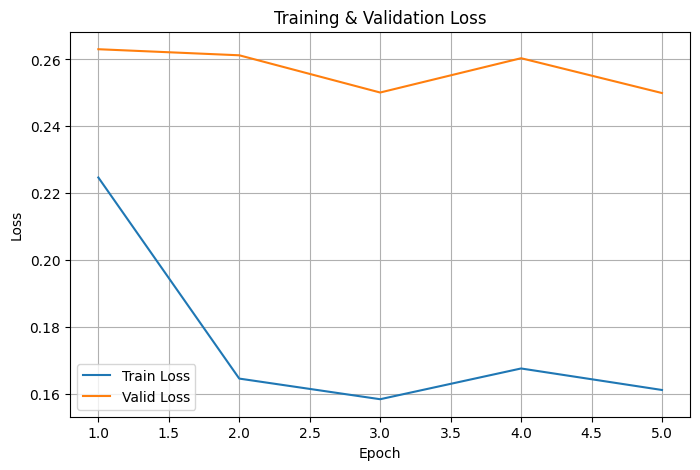

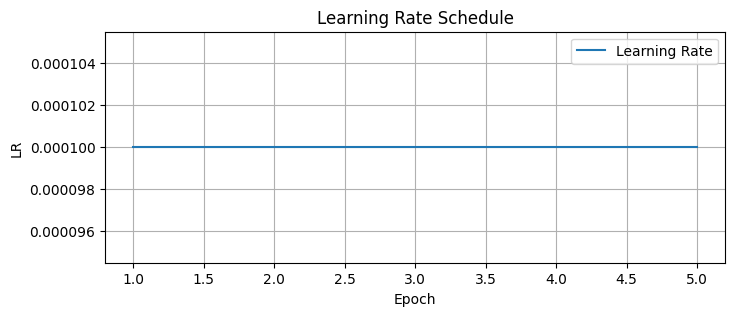

In [ ]:
for epoch in range(1, num_epochs + 1):

    #  Train for one epoch
    encoder.train()
    pbar_train = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Train Epoch {epoch}/{num_epochs}"
    )
    running_train_loss = 0.0

    for idx, (anchor, positive, negative) in pbar_train:
      anchor   = anchor.to(device, non_blocking=True)
      positive = positive.to(device, non_blocking=True)
      negative = negative.to(device, non_blocking=True)

      optimizer.zero_grad()
      anchor_embed   = encoder(anchor)
      positive_embed = encoder(positive)
      negative_embed = encoder(negative)

      loss_value = criterion(anchor_embed, positive_embed, negative_embed)
      loss_value.backward()
      optimizer.step()

      running_train_loss = (running_train_loss * idx + loss_value.item()) / (idx + 1)
      pbar_train.set_description(
       f"Train Epoch {epoch}/{num_epochs}, Loss: {running_train_loss:.3f}"
            )

    train_loss_epoch = running_train_loss

    #  Validate for one epoch
    encoder.eval()
    pbar_valid = tqdm(
        enumerate(valid_loader),
        total=len(valid_loader),
        desc=f"Valid Epoch {epoch}/{num_epochs}"
    )
    running_valid_loss = 0.0
    total_valid_loss   = 0.0

    with torch.no_grad():
        for idx, (anchor, positive, negative) in pbar_valid:
            anchor   = anchor.to(device, non_blocking=True)
            positive = positive.to(device, non_blocking=True)
            negative = negative.to(device, non_blocking=True)

            anchor_embed   = encoder(anchor)
            positive_embed = encoder(positive)
            negative_embed = encoder(negative)

            loss_value = criterion(anchor_embed, positive_embed, negative_embed)
            total_valid_loss += loss_value.item()
            running_valid_loss = (running_valid_loss * idx + loss_value.item()) / (idx + 1)

            pbar_valid.set_description(
                f"Valid Epoch {epoch}/{num_epochs}, Loss: {running_valid_loss:.3f}"
            )

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_loss_epoch = avg_valid_loss

    current_lr = optimizer.param_groups[0]["lr"]

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss_epoch,
        "valid_loss": valid_loss_epoch,
        "learning_rate": current_lr
    })

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss_epoch)
    history["valid_loss"].append(valid_loss_epoch)
    history["learning_rate"].append(current_lr)

    with open(csv_log_path, "a", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow([
            epoch,
            f"{train_loss_epoch:.6f}",
            f"{valid_loss_epoch:.6f}",
            f"{current_lr:.6e}"
        ])

    if valid_loss_epoch < best_validation_loss:
        torch.save({
            "model_state_dict": encoder.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }, "verification_model.pt")
        best_validation_loss  = valid_loss_epoch
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("Early stopping triggered.")
            break

wandb.finish()

plt.figure(figsize=(8, 5))
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(history["epoch"], history["learning_rate"], label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid()
plt.legend()
plt.show()

In [ ]:
torch.save(encoder, f"{save_path}/model_5ep.pth")

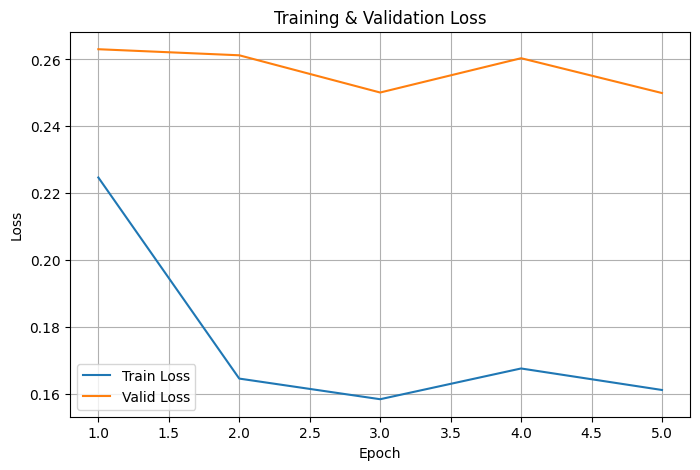

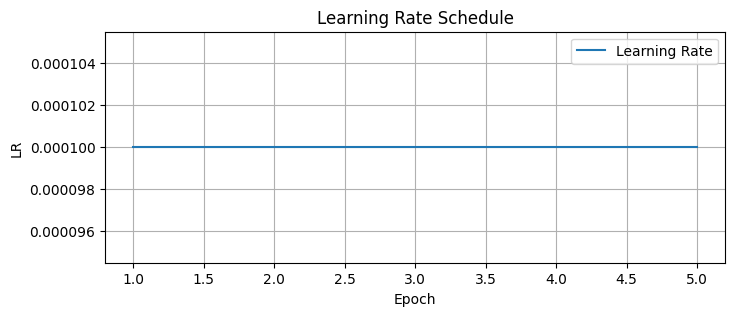

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(history["epoch"], history["learning_rate"], label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Reload best model
encoder = models.resnet18(pretrained=True).cuda()
encoder.fc = nn.Identity()
checkpoint = torch.load('verification_model.pt', map_location='cuda:0')
encoder.load_state_dict(checkpoint['model_state_dict'])
encoder.eval()

In [ ]:
# Reload best model
encoder = models.resnet18(pretrained=True).cuda()
encoder.fc = nn.Identity()
encoder = torch.load(f"{save_path}/model_5ep.pth", map_location='cuda:0',weights_only = False)
encoder.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Section 6: Validation & Threshold Selection


In [ ]:
valid_ver_loader = DataLoader(
    valid_verification_dataset,
    sampler=SubsetRandomSampler(range(len(valid_verification_dataset))),
    batch_size=1,
    num_workers=0,
    drop_last=True,
    pin_memory=True
)

distances = np.zeros(len(valid_verification_dataset))
targets = np.zeros(len(valid_verification_dataset))

In [ ]:
with torch.no_grad():
    for idx, (lhs, rhs, target) in enumerate(valid_ver_loader):
        lhs = lhs.cuda()
        rhs = rhs.cuda()
        lhs_embed = encoder(lhs)
        rhs_embed = encoder(rhs)

        distances[idx] = (lhs_embed - rhs_embed).pow(2).sum().sqrt().item()
        targets[idx] = target

In [ ]:
num_steps = 20000
tpr = np.zeros(num_steps)
fpr = np.zeros(num_steps)
precision = np.zeros(num_steps)
recall = np.zeros(num_steps)

thresholds = np.linspace(distances.min() + 0.01, distances.max() - 0.01, num_steps)
for i, thresh in enumerate(thresholds):
    preds = (distances < thresh).astype(int)
    tp = ((preds == 1) & (targets == 1)).sum()
    fp = ((preds == 1) & (targets == 0)).sum()
    tn = ((preds == 0) & (targets == 0)).sum()
    fn = ((preds == 0) & (targets == 1)).sum()

    tpr[i] = tp / (tp + fn + 1e-8)
    fpr[i] = fp / (fp + tn + 1e-8)
    precision[i] = tp / (tp + fp + 1e-8)
    recall[i] = tp / (tp + fn + 1e-8)

f1_score = 2 * precision * recall / (precision + recall + 1e-8)

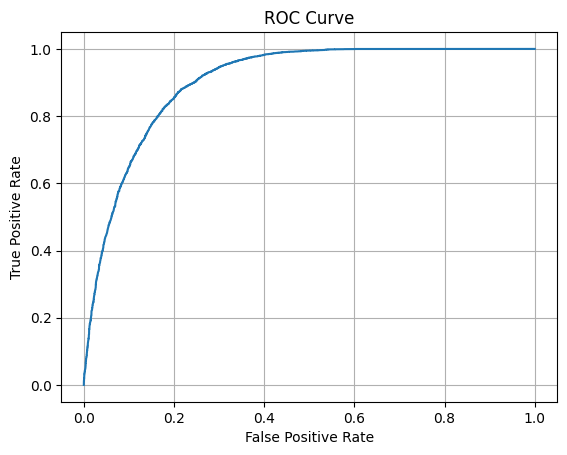

In [ ]:
# Построение ROC curve
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

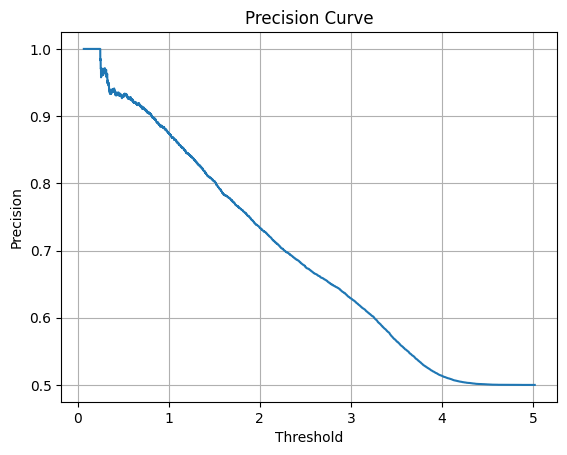

In [ ]:
# Построение precision curve
plt.figure()
plt.plot(thresholds, precision)
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.grid()
plt.show()

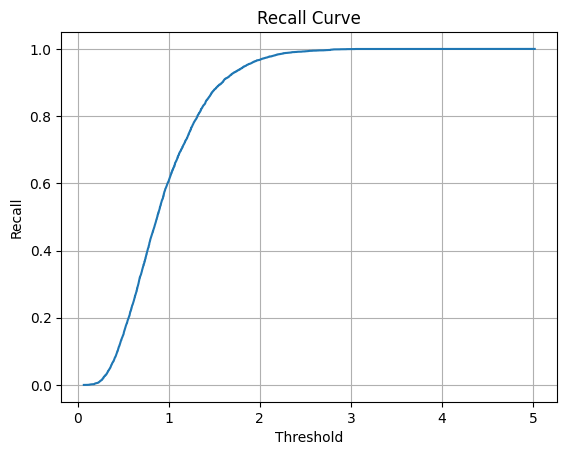

In [ ]:
# Построение recall curve
plt.figure()
plt.plot(thresholds, recall)
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.grid()
plt.show()

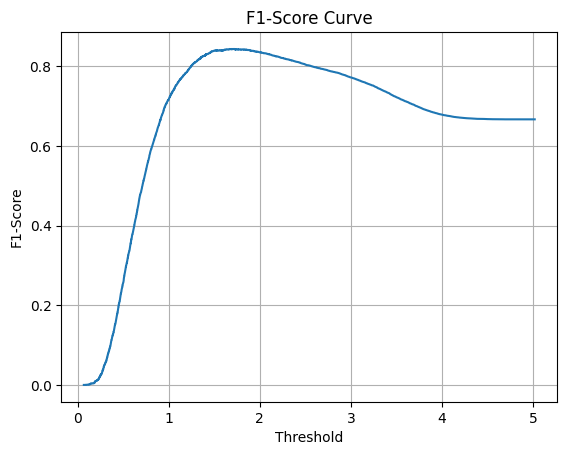

In [ ]:
# Построение F1-score curve
plt.figure()
plt.plot(thresholds, f1_score)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.grid()
plt.show()

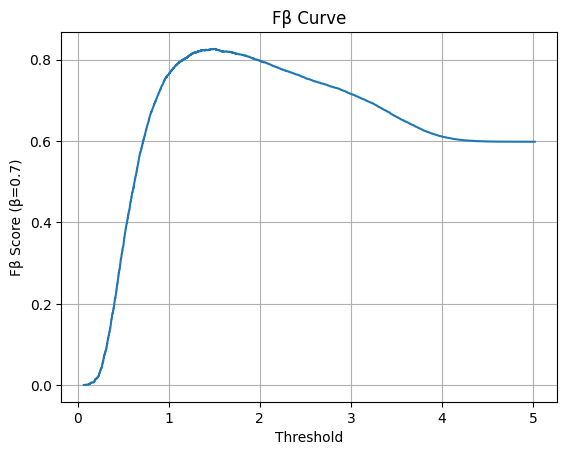

In [ ]:
# Построение Fβ (β = 0.7) кривой
beta = 0.7
f_beta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-8)

plt.figure()
plt.plot(thresholds, f_beta)
plt.xlabel('Threshold')
plt.ylabel('Fβ Score (β=0.7)')
plt.title('Fβ Curve')
plt.grid()
plt.show()

In [ ]:
# Выбирраем threshold для максимального F1
best_thresh_f1 = thresholds[np.argmax(f1_score)]
print(f"Selected threshold (max F1): {best_thresh_f1:.4f}")

Selected threshold (max F1): 1.6701


In [ ]:
# Дополнительно т выбираем threshold для максимального Fβ
best_thresh_fb = thresholds[np.argmax(f_beta)]
print(f"Selected threshold (max Fβ): {best_thresh_fb:.4f}")

Selected threshold (max Fβ): 1.4999


In [ ]:
# в итоге используем f1
threshold = best_thresh_f1

# Section 7: Testing the Model

In [ ]:
test_verification_dataset = FaceDatasetVerification(verification_test_df)

In [ ]:
tp = fp = tn = fn = 0
encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

test_ver_loader = DataLoader(
    test_verification_dataset,
    sampler=SubsetRandomSampler(range(len(test_verification_dataset))),
    batch_size=1,
    num_workers=12,
    #drop_last=True,
    pin_memory=True
)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
with torch.no_grad():
    for lhs, rhs, target in test_ver_loader:
        lhs = lhs.cuda()
        rhs = rhs.cuda()
        lhs_embed = encoder(lhs)
        rhs_embed = encoder(rhs)

        distance = (lhs_embed - rhs_embed).pow(2).sum().sqrt().item()
        pred = int(distance < threshold)

        if pred == 1 and target.item() == 1:
            tp += 1
        elif pred == 1 and target.item() == 0:
            fp += 1
        elif pred == 0 and target.item() == 0:
            tn += 1
        elif pred == 0 and target.item() == 1:
            fn += 1

In [ ]:
precision_test = tp / (tp + fp + 1e-8)
recall_test = tp / (tp + fn + 1e-8)
f1_test = 2 * precision_test * recall_test / (precision_test + recall_test + 1e-8)

print(f"Test Recall:    {recall_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test F1-Score:  {f1_test:.4f}")

Test Recall:    0.9139
Test Precision: 0.7794
Test F1-Score:  0.8413


# Section 8: Demonstration on Sample Images


In [ ]:
train_data_id = pd.read_csv(output_dir / 'train_data_id.csv')
test_data_id  = pd.read_csv(output_dir / 'test_data_id.csv')

In [ ]:
test_data_id.tail()

,path,id
19957,/content/drive/MyDrive/ml_hw5/celeba/img_align...,9761
19958,/content/drive/MyDrive/ml_hw5/celeba/img_align...,7192
19959,/content/drive/MyDrive/ml_hw5/celeba/img_align...,9852
19960,/content/drive/MyDrive/ml_hw5/celeba/img_align...,5570
19961,/content/drive/MyDrive/ml_hw5/celeba/img_align...,10101


In [ ]:
# Проверка на пересечение
assert set(test_data_id.id).isdisjoint(set(train_data_id.id)), "Train and test IDs must not overlap."

In [ ]:
# Отбираем test IDs у которых >15 images
uniques, counts = np.unique(test_data_id.id, return_counts=True)
valid_test_ids = uniques[counts > 15]
test_data_id = test_data_id[test_data_id.id.isin(valid_test_ids)]

# Рандомно выбираем один ID
chosen_id = np.random.choice(valid_test_ids, 1, replace=False)[0]
print(f"Selected reference ID: {chosen_id}")

Selected reference ID: 9584


In [ ]:
# Build a small test set: 1 reference + 5 same-ID + 10 different-ID
reference_row = test_data_id[test_data_id.id == chosen_id].iloc[0]
same_id_rows = test_data_id[test_data_id.id == chosen_id].iloc[1:6]
other_rows = test_data_id[test_data_id.id != chosen_id].sample(10)
test_paths = pd.concat([same_id_rows, other_rows], ignore_index=True)

In [ ]:
# Prepare reference image
transforms = A.Compose([A.Normalize(), ToTensor()])
ref_img = imread(reference_row.path)
ref_tensor = transforms(image=ref_img)['image'].unsqueeze(0).cuda()
ref_embed = encoder(ref_tensor)

In [ ]:
# Evaluate on the 15 samples
tp = tn = fp = fn = 0
for idx, row in test_paths.iterrows():
    curr_img = imread(row.path)
    curr_tensor = transforms(image=curr_img)['image'].unsqueeze(0).cuda()
    curr_embed = encoder(curr_tensor)

    distance = (ref_embed - curr_embed).pow(2).sum().sqrt().item()
    pred = int(distance < threshold)
    target = int(row.id == reference_row.id)

    if pred == 1 and target == 1:
        tp += 1
    elif pred == 1 and target == 0:
        fp += 1
    elif pred == 0 and target == 0:
        tn += 1
    elif pred == 0 and target == 1:
        fn += 1

In [ ]:
print(f"Out of 10 different-ID images, correctly flagged as different: {tn}")
print(f"Out of 5 same-ID images, correctly flagged as same:      {tp}")

Out of 10 different-ID images, correctly flagged as different: 10
Out of 5 same-ID images, correctly flagged as same:      5
